## numba powered mandelbrot function

In [1]:
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer
import numba

@numba.autojit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  
  c = complex(x, y)
  z = 0.0j
  for i in xrange(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@numba.autojit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

    
  for x in xrange(width):
    real = min_x + x * pixel_size_x
    for y in xrange(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color
  return image

## Opencl kernel for calculating mandelbrot

In [2]:
%%file mandelbrot.cl

	__kernel void mandelbrot(__global int *output, constant int* maxiter , 
                     constant float* p_size_x, constant float* p_size_y,
                     constant float* min_x, constant float* min_y)
    {
        int row = get_global_id(0);
        int col = get_global_id(1);
        
        int numRows = get_global_size(0);
        int numCols = get_global_size(1);
	
        int gid = col+ row*numCols;
        
        float real, imag, nreal = 0.0f;
        float oreal = min_x[0] + col * p_size_x[0] ;
        float oimag = min_y[0] + row * p_size_y[0] ;
		

        output[gid] = maxiter[0];
       for(int curiter = 0; curiter < maxiter[0]; curiter++) {
           nreal = real*real - imag*imag + oreal;
           imag = 2.0f* real*imag + oimag;
           real = nreal;
		   

		   if ((real*real + imag*imag) >= 4.0f){
                output[gid] = curiter;
				curiter = maxiter[0];
			}
       }
    }

Overwriting mandelbrot.cl


## Code for doing the mandelbrot calculation and comparison vs numba

Device name: GeForce GTX 780M
Device type: GPU
Max iterations: 10
opencl accalerated: 11.1233 ms
numba accalerated: 37.3206 ms
Opencl is 3.35517x times faster
Max iterations: 20
opencl accalerated: 12.2498 ms
numba accalerated: 58.5353 ms
Opencl is 4.77849x times faster
Max iterations: 100
opencl accalerated: 11.8922 ms
numba accalerated: 218.123 ms
Opencl is 18.3417x times faster
Max iterations: 500
opencl accalerated: 13.558 ms
numba accalerated: 969.229 ms
Opencl is 71.4879x times faster
Max iterations: 1000
opencl accalerated: 19.5763 ms
numba accalerated: 1881.9 ms
Opencl is 96.1314x times faster
Max iterations: 10000
opencl accalerated: 139.305 ms
numba accalerated: 18419 ms
Opencl is 132.221x times faster


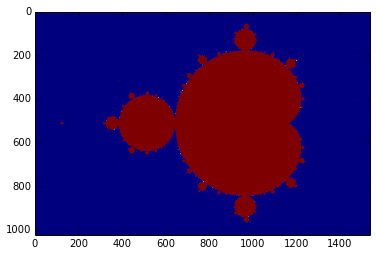

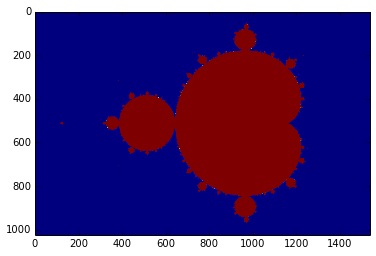


Arrays are not equal

(mismatch 0.38096110026%)
 x: array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],...
 y: array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],...


In [11]:
import numpy as np
import pyopencl as cl
from pylab import imshow, show
from numpy.testing import assert_equal
from time import clock

import os 

os.environ['PYOPENCL_COMPILER_OUTPUT'] = '0'

class CL:
    def __init__(self,device):
        self.ctx = cl.Context([device])
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

    def loadProgram(self, filename):
        """read in the OpenCL source file as a string"""
        f = open(filename, 'r')
        fstr = "".join(f.readlines())
        
        #print fstr #Uncomment to print the kernel code
        #Compiles the kernel (if not in cache)
        self.program = cl.Program(self.ctx, fstr).build()

    def execute(self,min_x, max_x, min_y, max_y,image, maxiter):
        """
        Executes the downsample(part1) kernel of the loaded file
        Input is the img array and a cell tupple
        """
        mf = cl.mem_flags

        #initialize client side (CPU) arrays
		
        height = image.shape[0]
        width = image.shape[1]

        pixel_size_x = (max_x - min_x) / width
        pixel_size_y = (max_y - min_y) / height
		
        
        
        #create OpenCL buffers

        #out_buf = cl.Buffer(self.ctx, mf.WRITE_ONLY | mf.USE_HOST_PTR, hostbuf=image)
        out_buf = cl.Buffer(self.ctx, mf.WRITE_ONLY, image.nbytes)
		
        maxiter_buf = cl.Buffer(self.ctx, mf.READ_ONLY | mf.USE_HOST_PTR, hostbuf=np.array([maxiter],dtype=np.int))
        pixel_size_x_buf = cl.Buffer(self.ctx, mf.READ_ONLY | mf.USE_HOST_PTR, hostbuf=np.array([pixel_size_x],dtype=np.float32))
        pixel_size_y_buf = cl.Buffer(self.ctx, mf.READ_ONLY | mf.USE_HOST_PTR, hostbuf=np.array([pixel_size_y],dtype=np.float32))
        min_x_buf = cl.Buffer(self.ctx, mf.READ_ONLY | mf.USE_HOST_PTR, hostbuf=np.array([min_x],dtype=np.float32))
        min_y_buf = cl.Buffer(self.ctx, mf.READ_ONLY | mf.USE_HOST_PTR, hostbuf=np.array([min_y],dtype=np.float32))
		
		
        #profiling 
        exec_evt = self.program.mandelbrot(self.queue, image.shape, None, out_buf, maxiter_buf,
											pixel_size_x_buf, pixel_size_y_buf,
											min_x_buf, min_y_buf)
        exec_evt.wait()
        self.elapsed = 1e-9*(exec_evt.profile.end - exec_evt.profile.start)
        
        #Reads the buffer back to the array
        
        cl.enqueue_read_buffer(self.queue, out_buf, image).wait()
        return (image)


#Getting the device to use with opencl    
devices = [device for platforms in cl.get_platforms() for device in platforms.get_devices()]
deviceUsed = devices[0]

example = CL(deviceUsed)
example.loadProgram("mandelbrot.cl")

#Code for shifting and zooming the area. 
xoffset = 0
yoffset = 0
zoomFactor = 1

x = np.array([-2.0, 1.0]) + xoffset
y = np.array([-1.0, 1.0]) + yoffset
xdif = (x[1] - x[0])
ydif = (y[1] - y[0])
xmid = x[0] + xdif/2
ymid = y[0] + (y[1] - y[0])/2


x = np.array([xmid - (xdif/(2*zoomFactor)), xmid + xdif/(2*zoomFactor)])
y = np.array([ymid - (ydif/(2*zoomFactor)), ymid + ydif/(2*zoomFactor)])

print "Device name:", deviceUsed.name
print "Device type:", cl.device_type.to_string(deviceUsed.type)

for maxiter in [10,20,100,500,1000,10000]:

    image = np.zeros((1024, 1536), dtype = np.int) 
    t0 = clock()
    result_opencl = example.execute(x[0], x[1], y[0], y[1], image, maxiter)
    t1 = clock()
    
    print '='*30
    print "Max iterations: %g" %maxiter
    print "opencl accalerated: %g ms"%((t1 - t0) * 1000) 
    
    
    image = np.zeros((1024, 1536), dtype = np.int) 
    t2 = clock()
    result_numba = create_fractal(x[0], x[1], y[0], y[1], image, maxiter)
    t3 = clock()
    print "numba accalerated: %g ms"%((t3 - t2) * 1000) 
    
    print "Opencl is %gx times faster" % ((t3 - t2)/(t1 - t0)) 
imshow(result_opencl)
show()
imshow(result_numba)
show()


#There seems to be some small differences in the results, when increasing the iterations and\or changing the view.
#Probably rounding errors. Becouse visually the results looks the same all the time. 
try: 
    assert_equal(result_numba, result_opencl)
    print "Equal"
except AssertionError as e:
    print e


In [4]:
%load_ext cythonmagic

In [5]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.cdivision(True)
cdef float mymean(float [:,:] x) nogil:
    cdef int xs, ys
    cdef float s = 0.
    cdef int i, j
    xs, ys = x.shape[0], x.shape[1]
    for i in prange(xs):
    #for i in prange(xs, schedule='static'):  # give this a try
        for j in range(ys):
            s += x[i,j]
    return s / (xs * ys)

@cython.boundscheck(False)
def downsample_cython5(x, cell):
    cdef int c0 = cell[0], c1 = cell[1]
    cdef int ys0 = x.shape[0] // c0
    cdef int ys1 = x.shape[1] // c1
    cdef int i, j
    y = np.empty((ys0, ys1), x.dtype)
    cdef float [:, :] y_view = y 
    cdef float [:, :] x_view = x
    with nogil:
        for i in range(ys0):
            for j in range(ys1):
                y_view[i, j] = mymean(x_view[i*c0:(i+1)*c0,j*c1:(j+1)*c1])
    return y

In [6]:
%%file downsample.cl

//a is the original image
//b is the downsampled image
__kernel void downsample(__global float* a, __global float* b, constant int* aShape, constant int* Cell )
{

	int row = get_global_id(1);
	int col = get_global_id(0);

	int numRows = get_global_size(1);
	int numCols = get_global_size(0);

	int gid = col+ row*numCols;
	
	int CellX = Cell[0];
	int CellY = Cell[1];
	
	int Arow = row*CellX;
	int Acol = col*CellY;
	
	int AnumRows = aShape[0];
	int AnumCols = aShape[1];
	
	//Here we map the index of the downscaled image to the original.
	int Agid = Acol+ Arow*AnumCols;
	
	
	float s = 0.0f;

	for(int i = 0; i < CellX; i++){
			for(int j = 0 ; j < CellY; j++){
				s += a[(Agid + i*aShape[0]) + j];
		}
	}
	b[gid] = s/(1.0f * CellX * CellY);
}

Overwriting downsample.cl


In [8]:
import pyopencl as cl
import numpy as np
import skimage.transform

class CL:
    def __init__(self,device):
        self.ctx = cl.Context([device])
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

    def loadProgram(self, filename):
        """read in the OpenCL source file as a string"""
        f = open(filename, 'r')
        fstr = "".join(f.readlines())
        
        #print fstr #Uncomment to print the kernel code
        #Compiles the kernel (if not in cache)
        self.program = cl.Program(self.ctx, fstr).build()

    def execute(self,a, cell):
        """
        Executes the downsample(part1) kernel of the loaded file
        Input is the img array and a cell tupple
        """
        mf = cl.mem_flags

        #initialize client side (CPU) arrays
        c0, c1 = cell
        yshape = (a.shape[0] // c0, a.shape[1] // c1)
        b = np.empty(yshape, a.dtype)
        
        #create OpenCL buffers
        a_buf = cl.Buffer(self.ctx, mf.READ_ONLY | mf.USE_HOST_PTR, hostbuf=a)
        b_buf = cl.Buffer(self.ctx, mf.WRITE_ONLY, b.nbytes)
        aShape_buf = cl.Buffer(self.ctx, mf.READ_ONLY | mf.USE_HOST_PTR, hostbuf=np.array([a.shape[0],a.shape[1]],dtype=int))
        cell_buf = cl.Buffer(self.ctx, mf.READ_ONLY | mf.USE_HOST_PTR, hostbuf=np.array([c0,c1]))
		
        #profiling 
        exec_evt = self.program.downsample(self.queue, b.shape, None, a_buf, b_buf, aShape_buf, cell_buf)
        exec_evt.wait()
        self.elapsed = 1e-9*(exec_evt.profile.end - exec_evt.profile.start)
        
        #Reads the buffer back to the array
        cl.enqueue_read_buffer(self.queue, b_buf, b).wait()
        return (b)

    

n = 2
img = np.arange(2**24, dtype=np.float32).reshape(2**12, 2**12)
for platform in cl.get_platforms():
    for device in platform.get_devices():
        print '='*30
        print("Device name:", device.name)
        example = CL(device)
        example.loadProgram("downsample.cl")
        
        %timeit example.execute(img, (n,n))
        #The 'actual' computation speed is without the time used to create, and read back, the arrays and buffers.
        print "Actualt computation speed: %g ms" %(1000*example.elapsed)
        


print '='*30
print("Cython speed: ")
%timeit downsample_cython5(img,(n,n))
print '='*30
print("skimage speed: ")
%timeit skimage.transform.downscale_local_mean(img, (n,n))
down_cl = downsample_cython5(img,(n,n))
down5 = downsample_cython5(img,(n,n))
np.allclose(down_cl, down5)

('Device name:', 'GeForce GTX 780M')
10 loops, best of 3: 21.2 ms per loop
Actualt computation speed: 1.10576 ms
('Device name:', 'Intel(R) HD Graphics 4600')
10 loops, best of 3: 22 ms per loop
Actualt computation speed: 23.2033 ms
('Device name:', 'Intel(R) Core(TM) i7-4700MQ CPU @ 2.40GHz')
10 loops, best of 3: 41.7 ms per loop
Actualt computation speed: 9.34361 ms
Cython speed: 
1 loops, best of 3: 205 ms per loop
skimage speed: 
10 loops, best of 3: 166 ms per loop


True

The 'Actual computation speed' could be relevant if you we're to do more computation on the downsampled image, since you could use the same buffer as input for a new kernel. And would not have to waste time for transfering the data to the gpu again. 